# Project 1

**Dataset:** Speed dating


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import scipy.stats as stats
import pandas as pd
from sympy import timed


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import random

torch.manual_seed(0)
np.random.seed(0)

random.seed(0)

In [146]:
import wandb
import getpass


super_secret_API_key = "d1678741bcd8eb1d90ca26aa8f2bf079256ac391"

wandb.login(key=super_secret_API_key)

WANDB_PROJECT = "ZNEUS_project1"
WANDB_ENTITY = None  # getpass.getuser()
# ak to chceme pouzivat, tak si tu budes musiet spravit ucet aby som ti mohol dat pristup
# https://wandb.ai/bizon-mimi-stu/ZNEUS_project1/workspace?nw=nwuserbizonmimi

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\bizon\_netrc


In [218]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 122)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(122, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 8)
        self.fc5 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.sigmoid(self.fc5(x))
        return x


def train_model(
    X_train,
    y_train,
    X_val=None,
    y_val=None,
    num_epochs=5000,
    learning_rate=0.001,
    use_wandb=True,
    run_name=None,
    patience=200,
    min_delta=0.0001,
):
    """
    Train a neural network model with optional WandB logging and early stopping.

    Args:
        X_train: Training features
        y_train: Training labels
        X_val: Validation features (if None, will split from training data)
        y_val: Validation labels
        num_epochs: Maximum number of training epochs
        learning_rate: Learning rate for optimizer
        use_wandb: Whether to log to WandB (default: True)
        run_name: Optional name for the WandB run
        patience: Number of epochs to wait for improvement before stopping
        min_delta: Minimum change in validation loss to be considered improvement

    Returns:
        model: Trained model
        scaler: Fitted StandardScaler
        history: Dictionary with training history
    """

    # If no validation set provided, split from training data
    if X_val is None or y_val is None:
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=0.15, random_state=42
        )
        print(f"Split training data: {len(X_train)} train, {len(X_val)} validation")

    # Initialize WandB
    if use_wandb:
        try:
            init_config = {
                "project": WANDB_PROJECT,
                "name": run_name,
                "config": {
                    "learning_rate": learning_rate,
                    "max_epochs": num_epochs,
                    "architecture": "SimpleNN",
                    "hidden_layers": [16, 8],
                    "optimizer": "Adam",
                    "loss_function": "BCELoss",
                    "input_features": X_train.shape[1],
                    "training_samples": X_train.shape[0],
                    "validation_samples": X_val.shape[0],
                    "patience": patience,
                    "min_delta": min_delta,
                },
            }

            if WANDB_ENTITY is not None:
                init_config["entity"] = WANDB_ENTITY

            wandb.init(**init_config)
            config = wandb.config
            print("✓ WandB run initialized successfully")
        except Exception as e:
            print(f"⚠ WandB initialization failed: {e}")
            print("Continuing training without WandB logging...")
            use_wandb = False

    # Prepare data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

    # Initialize model
    model = SimpleNN(input_size=X_train.shape[1])

    # Log model architecture to WandB
    if use_wandb:
        wandb.watch(model, log="all", log_freq=100)

    # Calculate class weights for unbalanced dataset
    num_pos = np.sum(y_train == 1)
    num_neg = np.sum(y_train == 0)
    pos_weight = num_neg / num_pos

    if use_wandb:
        wandb.config.update(
            {
                "positive_samples": int(num_pos),
                "negative_samples": int(num_neg),
                "class_weight_ratio": pos_weight,
            }
        )

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Early stopping variables
    best_val_loss = float("inf")
    best_model_state = None
    patience_counter = 0
    best_epoch = 0

    # History tracking
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    # Training loop
    print(f"\nStarting training with early stopping (patience={patience})...")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        train_loss = criterion(outputs, y_train_tensor)
        train_loss.backward()
        optimizer.step()

        # Calculate training accuracy
        with torch.no_grad():
            y_pred_labels = (outputs > 0.5).float()
            train_accuracy = (
                y_pred_labels.eq(y_train_tensor).sum().item()
            ) / y_train_tensor.size(0)

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            val_pred_labels = (val_outputs > 0.5).float()
            val_accuracy = (
                val_pred_labels.eq(y_val_tensor).sum().item()
            ) / y_val_tensor.size(0)

        # Store history
        history["train_loss"].append(train_loss.item())
        history["train_acc"].append(train_accuracy)
        history["val_loss"].append(val_loss.item())
        history["val_acc"].append(val_accuracy)

        # Log metrics to WandB
        if use_wandb:
            wandb.log(
                {
                    "epoch": epoch + 1,
                    "train_loss": train_loss.item(),
                    "train_accuracy": train_accuracy,
                    "val_loss": val_loss.item(),
                    "val_accuracy": val_accuracy,
                    "patience_counter": patience_counter,
                }
            )

        # Early stopping check
        if val_loss < (best_val_loss - min_delta):
            best_val_loss = val_loss.item()
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            best_epoch = epoch + 1
        else:
            patience_counter += 1

        # Print progress every 100 epochs or at key moments
        if (epoch + 1) % 100 == 0 or epoch == 0 or patience_counter == 1:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}] - "
                f"Train Loss: {train_loss.item():.4f}, Train Acc: {train_accuracy:.4f} | "
                f"Val Loss: {val_loss.item():.4f}, Val Acc: {val_accuracy:.4f} | "
                f"Patience: {patience_counter}/{patience}"
            )

        # Stop if patience exceeded
        if patience_counter >= patience:
            print(f"\n🛑 Early stopping triggered at epoch {epoch + 1}")
            print(f"Best validation loss: {best_val_loss:.4f} at epoch {best_epoch}")
            model.load_state_dict(best_model_state)
            break

    # Load best model if training completed without early stopping
    if patience_counter < patience and best_model_state is not None:
        print(f"\n✓ Training completed. Loading best model from epoch {best_epoch}")
        model.load_state_dict(best_model_state)

    if use_wandb:
        wandb.log(
            {
                "best_epoch": best_epoch,
                "best_val_loss": best_val_loss,
                "total_epochs_trained": epoch + 1,
            }
        )

    return model, scaler, history


def evaluate_model(model, scaler, X_test, y_test, use_wandb=True):
    """
    Evaluate model on test set and optionally log to WandB.

    Args:
        model: Trained model
        scaler: Fitted StandardScaler
        X_test: Test features
        y_test: Test labels
        use_wandb: Whether to log to WandB (default: True)

    Returns:
        accuracy: Test accuracy
        predicted_array: Array of predictions
        metrics_dict: Dictionary with all metrics
    """
    model.eval()
    X_test_scaled = scaler.transform(X_test)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    with torch.no_grad():
        y_pred = model(X_test_tensor)
        y_pred_labels = (y_pred > 0.5).float()
        accuracy = (y_pred_labels.eq(y_test_tensor).sum().item()) / y_test_tensor.size(
            0
        )

        # Calculate additional metrics
        test_loss = nn.BCELoss()(y_pred, y_test_tensor).item()

        # Calculate precision, recall, F1
        true_positives = ((y_pred_labels == 1) & (y_test_tensor == 1)).sum().item()
        false_positives = ((y_pred_labels == 1) & (y_test_tensor == 0)).sum().item()
        false_negatives = ((y_pred_labels == 0) & (y_test_tensor == 1)).sum().item()
        true_negatives = ((y_pred_labels == 0) & (y_test_tensor == 0)).sum().item()

        precision = (
            true_positives / (true_positives + false_positives)
            if (true_positives + false_positives) > 0
            else 0
        )
        recall = (
            true_positives / (true_positives + false_negatives)
            if (true_positives + false_negatives) > 0
            else 0
        )
        f1 = (
            2 * (precision * recall) / (precision + recall)
            if (precision + recall) > 0
            else 0
        )

    predicted_array = y_pred_labels.cpu().numpy().flatten()

    # Create metrics dictionary
    metrics_dict = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "test_loss": test_loss,
        "true_positives": int(true_positives),
        "false_positives": int(false_positives),
        "false_negatives": int(false_negatives),
        "true_negatives": int(true_negatives),
    }

    # Log test metrics to WandB
    if use_wandb:
        wandb.log(
            {
                "test_accuracy": accuracy,
                "test_loss": test_loss,
                "test_precision": precision,
                "test_recall": recall,
                "test_f1": f1,
            }
        )

        # Create confusion matrix for WandB
        cm = confusion_matrix(y_test, predicted_array)
        wandb.log(
            {
                "confusion_matrix": wandb.plot.confusion_matrix(
                    probs=None,
                    y_true=y_test,
                    preds=predicted_array,
                    class_names=["No Match", "Match"],
                )
            }
        )

        wandb.finish()

    # Print detailed results
    print(f"\n{'=' * 50}")
    print(f"Test Results:")
    print(f"{'=' * 50}")
    print(f"Accuracy:  {accuracy:.4f} ({accuracy * 100:.2f}%)")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"\nConfusion Matrix:")
    print(f"  True Negatives:  {true_negatives}")
    print(f"  False Positives: {false_positives}")
    print(f"  False Negatives: {false_negatives}")
    print(f"  True Positives:  {true_positives}")
    print(f"{'=' * 50}\n")

    # Use sklearn's classification report for detailed metrics
    print("Detailed Classification Report:")
    print(
        classification_report(
            y_test, predicted_array, target_names=["No Match", "Match"]
        )
    )

    return accuracy, predicted_array, metrics_dict


def plot_training_history(history):
    """
    Plot training and validation loss/accuracy curves.

    Args:
        history: Dictionary with training history from train_model
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    epochs = range(1, len(history["train_loss"]) + 1)

    # Loss plot
    ax1.plot(epochs, history["train_loss"], "b-", label="Training Loss", linewidth=2)
    ax1.plot(epochs, history["val_loss"], "r-", label="Validation Loss", linewidth=2)
    ax1.set_xlabel("Epoch", fontsize=12)
    ax1.set_ylabel("Loss", fontsize=12)
    ax1.set_title("Training and Validation Loss", fontsize=14, fontweight="bold")
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(epochs, history["train_acc"], "b-", label="Training Accuracy", linewidth=2)
    ax2.plot(epochs, history["val_acc"], "r-", label="Validation Accuracy", linewidth=2)
    ax2.set_xlabel("Epoch", fontsize=12)
    ax2.set_ylabel("Accuracy", fontsize=12)
    ax2.set_title("Training and Validation Accuracy", fontsize=14, fontweight="bold")
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [148]:
df_dating = pd.read_csv("DATA/.ipynb_checkpoints/speeddating-checkpoint.csv")
df_dating.head(10)

C:\Users\bizon\AppData\Local\Temp\ipykernel_30356\4271667217.py:1: DtypeWarning: Columns (3,10,11,15,16,17,18,19,39,40,41,42,43,44,51,52,53,54,55,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,107,109) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dating = pd.read_csv("DATA/.ipynb_checkpoints/speeddating-checkpoint.csv")


,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,0,1,female,21,27,6,[4-6],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],7,6,[6-8],[5-6],0,1,0,0
1,0,1,female,21,22,1,[0-1],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],7,5,[6-8],[5-6],1,1,0,0
2,1,1,female,21,22,1,[0-1],'Asian/Pacific Islander/Asian-American','Asian/Pacific Islander/Asian-American',1,...,[0-3],[3-5],7,?,[6-8],[0-4],1,1,1,1
3,0,1,female,21,23,2,[2-3],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],7,6,[6-8],[5-6],0,1,1,1
4,0,1,female,21,24,3,[2-3],'Asian/Pacific Islander/Asian-American','Latino/Hispanic American',0,...,[0-3],[3-5],6,6,[6-8],[5-6],0,1,1,1
5,0,1,female,21,25,4,[4-6],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],6,5,[6-8],[5-6],0,0,1,0
6,0,1,female,21,30,9,[7-37],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],6,5,[6-8],[5-6],0,1,0,0
7,1,1,female,21,27,6,[4-6],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],6,7,[6-8],[7-10],?,0,0,0
8,0,1,female,21,28,7,[7-37],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],7,7,[6-8],[7-10],0,1,1,1
9,0,1,female,21,24,3,[2-3],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],6,6,[6-8],[5-6],0,1,0,0


In [149]:
df_dating.replace("?", np.nan, inplace=True)

In [150]:
df_dating.shape

(8378, 123)

In [151]:
df_dating.info

<bound method DataFrame.info of       has_null  wave  gender age age_o  d_age d_d_age  \
0            0     1  female  21    27      6   [4-6]   
1            0     1  female  21    22      1   [0-1]   
2            1     1  female  21    22      1   [0-1]   
3            0     1  female  21    23      2   [2-3]   
4            0     1  female  21    24      3   [2-3]   
...        ...   ...     ...  ..   ...    ...     ...   
8373         1    21    male  25    26      1   [0-1]   
8374         1    21    male  25    24      1   [0-1]   
8375         1    21    male  25    29      4   [4-6]   
8376         1    21    male  25    22      3   [2-3]   
8377         1    21    male  25    22      3   [2-3]   

                                         race  \
0     'Asian/Pacific Islander/Asian-American'   
1     'Asian/Pacific Islander/Asian-American'   
2     'Asian/Pacific Islander/Asian-American'   
3     'Asian/Pacific Islander/Asian-American'   
4     'Asian/Pacific Islander/Asian-Am

In [152]:
df_dating.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 123 columns):
 #    Column                           Dtype 
---   ------                           ----- 
 0    has_null                         int64 
 1    wave                             int64 
 2    gender                           object
 3    age                              object
 4    age_o                            object
 5    d_age                            int64 
 6    d_d_age                          object
 7    race                             object
 8    race_o                           object
 9    samerace                         int64 
 10   importance_same_race             object
 11   importance_same_religion         object
 12   d_importance_same_race           object
 13   d_importance_same_religion       object
 14   field                            object
 15   pref_o_attractive                object
 16   pref_o_sincere                   object
 17   pref_o_intel

In [153]:
missing_values = df_dating.isnull().sum().sort_values(ascending=False)

# Percentage of missing values
missing_percentage = (df_dating.isnull().mean() * 100).sort_values(ascending=False)

missing_df = pd.DataFrame(
    {"Missing Values": missing_values, "Percentage": missing_percentage}
)

print(missing_df.head(50))

                               Missing Values  Percentage
expected_num_interested_in_me            6578   78.515159
expected_num_matches                     1173   14.000955
shared_interests_o                       1076   12.843161
shared_interests_partner                 1067   12.735736
ambitous_o                                722    8.617809
ambition_partner                          712    8.498448
met                                       375    4.476009
funny_o                                   360    4.296968
funny_partner                             350    4.177608
guess_prob_liked                          309    3.688231
intelligence_o                            306    3.652423
intelligence_partner                      296    3.533063
sinsere_o                                 287    3.425639
sincere_partner                           277    3.306278
like                                      240    2.864646
attractive_o                              212    2.530437
attractive_par

In [154]:
df_dating = df_dating.drop(columns="expected_num_interested_in_me")

In [155]:
duplicates = df_dating.duplicated().sum()

print(f"Number of duplicate rows: {duplicates}")


# df = df.drop_duplicates()

Number of duplicate rows: 0


In [156]:
df_dating.dtypes.value_counts()  # How many numeric, object, etc.

categorical = df_dating.select_dtypes(include=["object"]).columns
for col in categorical[:10]:  # Show first 10 to avoid spam
    print(f"{col}: {df_dating[col].nunique()} unique values")

gender: 2 unique values
age: 30 unique values
age_o: 24 unique values
d_d_age: 4 unique values
race: 5 unique values
race_o: 5 unique values
importance_same_race: 17 unique values
importance_same_religion: 15 unique values
d_importance_same_race: 3 unique values
d_importance_same_religion: 3 unique values


In [157]:
df_dating["d_pref_o_attractive"].unique()

array(['[21-100]', '[16-20]', '[0-15]'], dtype=object)

In [158]:
df_dating["d_d_age"].unique()

array(['[4-6]', '[0-1]', '[2-3]', '[7-37]'], dtype=object)

In [159]:
df_dating["d_importance_same_religion"].unique()

array(['[2-5]', '[0-1]', '[6-10]'], dtype=object)

použit precision metric ---


In [160]:
df_dating.describe()

,has_null,wave,d_age,samerace,decision,decision_o,match
count,8378.00000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000
mean,0.87491,11.350919,4.185605,0.395799,0.419909,0.419551,0.164717
std,0.33084,5.995903,4.596171,0.489051,0.493573,0.493515,0.370947
min,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.00000,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.00000,11.000000,3.000000,0.000000,0.000000,0.000000,0.000000
75%,1.00000,15.000000,5.000000,1.000000,1.000000,1.000000,0.000000
max,1.00000,21.000000,37.000000,1.000000,1.000000,1.000000,1.000000


In [161]:
from sklearn.preprocessing import LabelEncoder

# Get all columns that contain range strings
range_cols = [col for col in df_dating.columns if col.startswith("d_")]

other_categorical = ["gender", "race", "race_o"]

cols_to_encode = range_cols + other_categorical

le = LabelEncoder()

for col in cols_to_encode:
    if col in df_dating.columns:
        if df_dating[col].dtype in ["object", "string"]:
            most_frequent = df_dating[col].mode()[0]
            df_dating[col] = df_dating[col].fillna(most_frequent)

            df_dating[col] = le.fit_transform(df_dating[col])

print("Encoded columns sample:")
print(df_dating[cols_to_encode].head())
print("\nData types:")
print(df_dating[cols_to_encode].dtypes)
print("\nUnique values in d_d_age:", df_dating["d_d_age"].unique())

Encoded columns sample:
   d_age  d_d_age  d_importance_same_race  d_importance_same_religion  \
0      6        2                       1                           1   
1      1        0                       1                           1   
2      1        0                       1                           1   
3      2        1                       1                           1   
4      3        1                       1                           1   

   d_pref_o_attractive  d_pref_o_sincere  d_pref_o_intelligence  \
0                    2                 1                      1   
1                    2                 0                      0   
2                    1                 1                      1   
3                    2                 0                      0   
4                    2                 0                      1   

   d_pref_o_funny  d_pref_o_ambitious  d_pref_o_shared_interests  ...  d_yoga  \
0               1                   0                

In [162]:
print("Total NaN values:", df_dating.isna().sum().sum())

print("\nNaN count per column:")
print(df_dating.isna().sum())

print("\nColumns with NaN:")
print(df_dating.isna().sum()[df_dating.isna().sum() > 0])

print("\nPercentage of NaN per column:")
print((df_dating.isna().sum() / len(df_dating)) * 100)

Total NaN values: 11658

NaN count per column:
has_null                0
wave                    0
gender                  0
age                    95
age_o                 104
                     ... 
d_guess_prob_liked      0
met                   375
decision                0
decision_o              0
match                   0
Length: 122, dtype: int64

Columns with NaN:
age                                95
age_o                             104
importance_same_race               79
importance_same_religion           79
field                              63
pref_o_attractive                  89
pref_o_sincere                     89
pref_o_intelligence                89
pref_o_funny                       98
pref_o_ambitious                  107
pref_o_shared_interests           129
attractive_o                      212
sinsere_o                         287
intelligence_o                    306
funny_o                           360
ambitous_o                        722
shared_interes

has_null              0.000000
wave                  0.000000
gender                0.000000
age                   1.133922
age_o                 1.241346
                        ...   
d_guess_prob_liked    0.000000
met                   4.476009
decision              0.000000
decision_o            0.000000
match                 0.000000
Length: 122, dtype: float64


In [163]:
from sklearn.impute import SimpleImputer

# Separate numeric and categorical
numeric_cols = df_dating.select_dtypes(include=["float64", "int64"]).columns
categorical_cols = df_dating.select_dtypes(include=["object", "string"]).columns

# Impute numeric with median
imputer_num = SimpleImputer(strategy="median")
df_dating[numeric_cols] = imputer_num.fit_transform(df_dating[numeric_cols])

# Impute categorical with most frequent
imputer_cat = SimpleImputer(strategy="most_frequent")
if len(categorical_cols) > 0:
    df_dating[categorical_cols] = imputer_cat.fit_transform(df_dating[categorical_cols])


In [164]:
print("Total NaN values:", df_dating.isna().sum().sum())

print("\nNaN count per column:")
print(df_dating.isna().sum())

print("\nColumns with NaN:")
print(df_dating.isna().sum()[df_dating.isna().sum() > 0])

print("\nPercentage of NaN per column:")
print((df_dating.isna().sum() / len(df_dating)) * 100)

Total NaN values: 0

NaN count per column:
has_null              0
wave                  0
gender                0
age                   0
age_o                 0
                     ..
d_guess_prob_liked    0
met                   0
decision              0
decision_o            0
match                 0
Length: 122, dtype: int64

Columns with NaN:
Series([], dtype: int64)

Percentage of NaN per column:
has_null              0.0
wave                  0.0
gender                0.0
age                   0.0
age_o                 0.0
                     ... 
d_guess_prob_liked    0.0
met                   0.0
decision              0.0
decision_o            0.0
match                 0.0
Length: 122, dtype: float64


In [165]:
df_dating.head(20)

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,0.0,1.0,0.0,21,27,6.0,2.0,0.0,3.0,0.0,...,0.0,1.0,7,6,1.0,1.0,0,1.0,0.0,0.0
1,0.0,1.0,0.0,21,22,1.0,0.0,0.0,3.0,0.0,...,0.0,1.0,7,5,1.0,1.0,1,1.0,0.0,0.0
2,1.0,1.0,0.0,21,22,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,7,5,1.0,0.0,1,1.0,1.0,1.0
3,0.0,1.0,0.0,21,23,2.0,1.0,0.0,3.0,0.0,...,0.0,1.0,7,6,1.0,1.0,0,1.0,1.0,1.0
4,0.0,1.0,0.0,21,24,3.0,1.0,0.0,2.0,0.0,...,0.0,1.0,6,6,1.0,1.0,0,1.0,1.0,1.0
5,0.0,1.0,0.0,21,25,4.0,2.0,0.0,3.0,0.0,...,0.0,1.0,6,5,1.0,1.0,0,0.0,1.0,0.0
6,0.0,1.0,0.0,21,30,9.0,3.0,0.0,3.0,0.0,...,0.0,1.0,6,5,1.0,1.0,0,1.0,0.0,0.0
7,1.0,1.0,0.0,21,27,6.0,2.0,0.0,3.0,0.0,...,0.0,1.0,6,7,1.0,2.0,0,0.0,0.0,0.0
8,0.0,1.0,0.0,21,28,7.0,3.0,0.0,3.0,0.0,...,0.0,1.0,7,7,1.0,2.0,0,1.0,1.0,1.0
9,0.0,1.0,0.0,21,24,3.0,1.0,0.0,3.0,0.0,...,0.0,1.0,6,6,1.0,1.0,0,1.0,0.0,0.0


In [166]:
df_dating["d_pref_o_attractive"].unique()

array([2., 1., 0.])

In [167]:
df_dating["d_d_age"].unique()

array([2., 0., 1., 3.])

In [168]:
df_dating["field"].unique()

array(['Law', 'law', 'Economics', "'Masters in Public Administration'",
       "'Masters of Social Work&Education'", 'Finance', 'Business',
       "'political science'", 'money', "'Operations Research'",
       "'TC [Health Ed]'", 'Psychology', "'social work'", "'Social Work'",
       "'Speech Language Pathology'", "'Speech Languahe Pathology'",
       "'Educational Psychology'", "'Applied Maths/Econs'", 'Mathematics',
       'Statistics', "'Organizational Psychology'",
       "'Mechanical Engineering'", 'Finanace', 'Finance&Economics',
       "'Undergrad - GS'", "'Mathematical Finance'", 'Medicine', 'MBA',
       'LAW', 'psychology', "'German Literature'",
       "'Business & International Affairs'", "'MFA Creative Writing'",
       'Engineering', "'Electrical Engineering'", 'Classics',
       "'Operations Research [SEAS]'", 'chemistry', 'Journalism',
       "'Elementary/Childhood Education [MA]'", 'microbiology',
       "'Masters of Social Work'", 'Communications', 'Marketing',
     

In [169]:
df_dating["d_importance_same_religion"].unique()

array([1., 0., 2.])

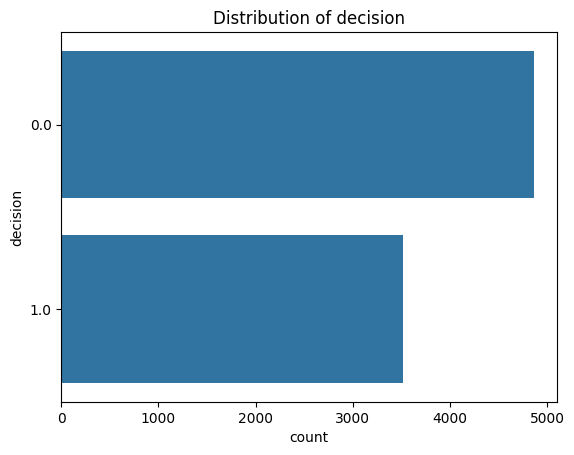

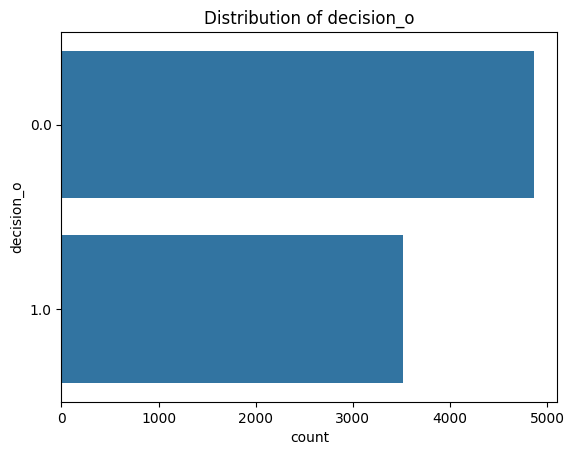

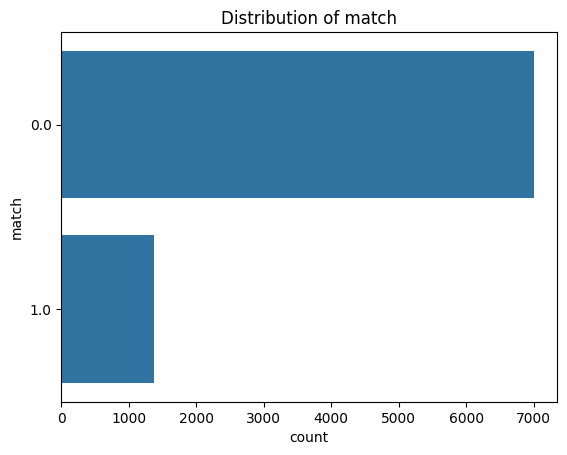

In [170]:
categorical = ["decision", "decision_o", "match"]
for col in categorical:
    sns.countplot(y=col, data=df_dating)
    plt.title(f"Distribution of {col}")
    plt.show()

# Precision matrix?


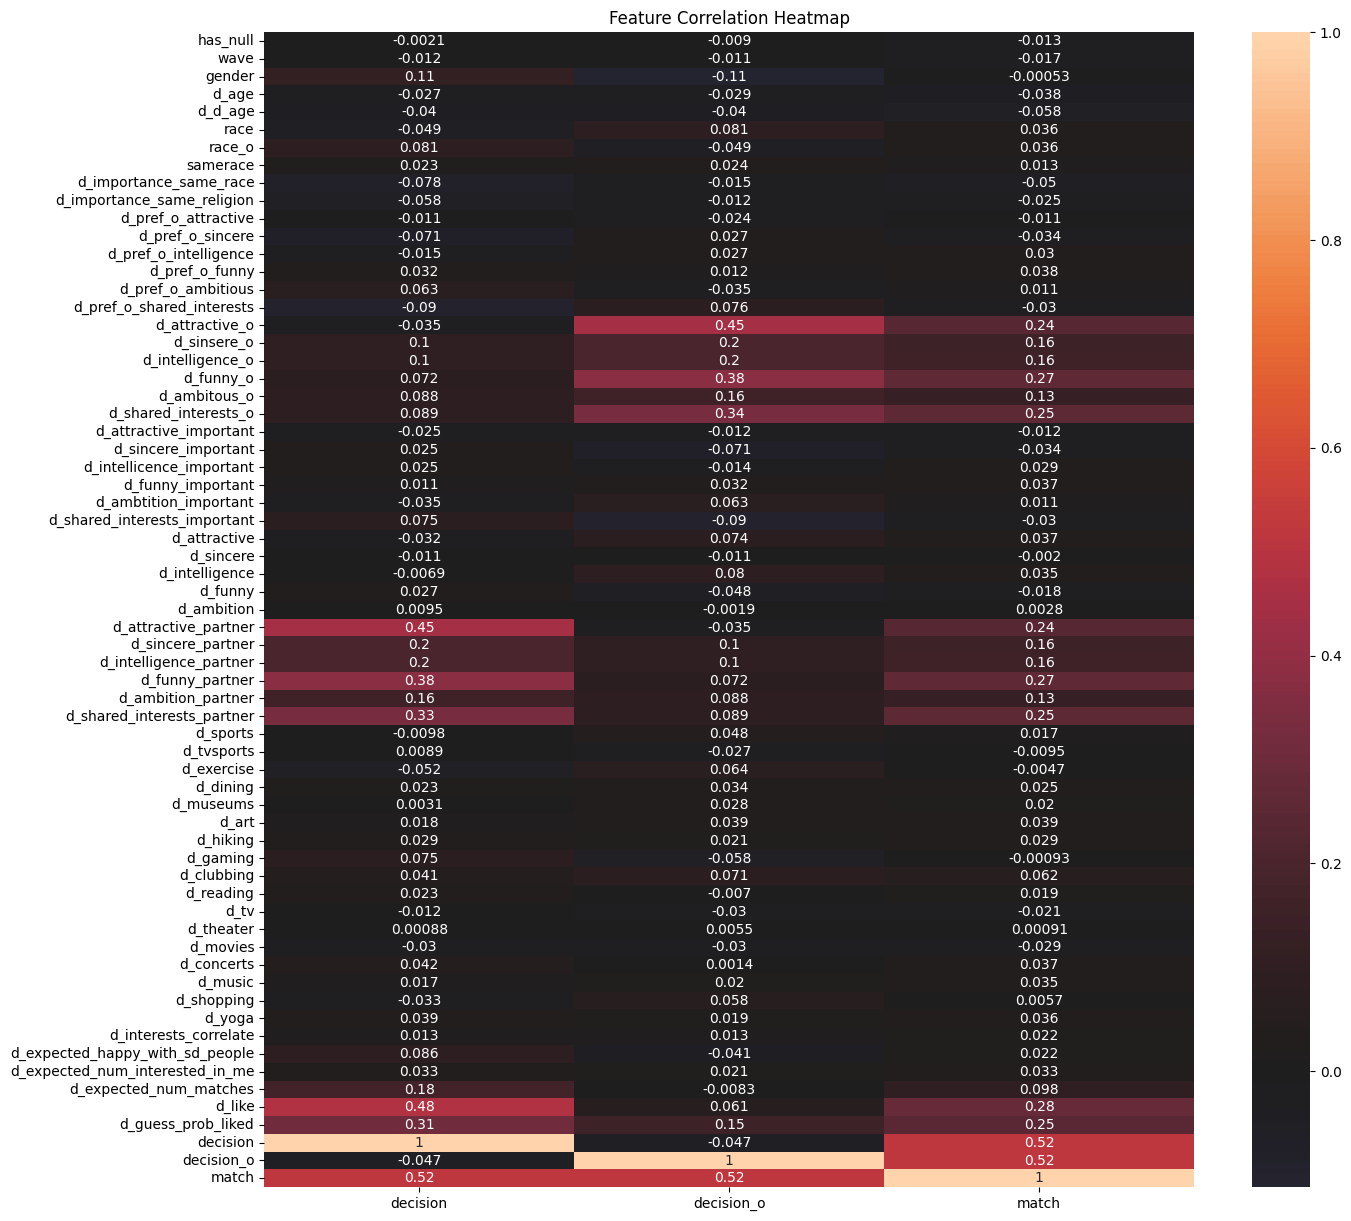

In [171]:
corr = df_dating.corr(numeric_only=True)

subset_corr = corr.loc[:, ["decision", "decision_o", "match"]]

plt.figure(figsize=(15, 15))
sns.heatmap(subset_corr, center=0, annot=True)
plt.title("Feature Correlation Heatmap")
plt.show()

In [172]:
corr["decision"].sort_values(ascending=False).head(20)

decision                           1.000000
match                              0.521943
d_like                             0.482794
d_attractive_partner               0.452035
d_funny_partner                    0.375847
d_shared_interests_partner         0.334538
d_guess_prob_liked                 0.305509
d_sincere_partner                  0.202775
d_intelligence_partner             0.202662
d_expected_num_matches             0.177573
d_ambition_partner                 0.158678
gender                             0.110232
d_intelligence_o                   0.101195
d_sinsere_o                        0.100253
d_shared_interests_o               0.089353
d_ambitous_o                       0.087603
d_expected_happy_with_sd_people    0.085549
race_o                             0.080640
d_shared_interests_important       0.075493
d_gaming                           0.074709
Name: decision, dtype: float64

In [173]:
corr["decision_o"].sort_values(ascending=False).head(20)

decision_o                    1.000000
match                         0.522326
d_attractive_o                0.452818
d_funny_o                     0.376403
d_shared_interests_o          0.335046
d_sinsere_o                   0.203872
d_intelligence_o              0.203411
d_ambitous_o                  0.159231
d_guess_prob_liked            0.152864
d_intelligence_partner        0.100928
d_sincere_partner             0.099916
d_shared_interests_partner    0.089296
d_ambition_partner            0.087826
race                          0.080986
d_intelligence                0.079555
d_pref_o_shared_interests     0.075861
d_attractive                  0.074198
d_funny_partner               0.071757
d_clubbing                    0.070865
d_exercise                    0.064161
Name: decision_o, dtype: float64

In [174]:
corr["match"].sort_values(ascending=False).head(20)

match                         1.000000
decision_o                    0.522326
decision                      0.521943
d_like                        0.284972
d_funny_o                     0.266087
d_funny_partner               0.265523
d_shared_interests_o          0.252072
d_shared_interests_partner    0.251726
d_guess_prob_liked            0.246707
d_attractive_o                0.243062
d_attractive_partner          0.242534
d_intelligence_o              0.162352
d_intelligence_partner        0.161662
d_sinsere_o                   0.155709
d_sincere_partner             0.155004
d_ambitous_o                  0.133441
d_ambition_partner            0.133101
d_expected_num_matches        0.098002
d_clubbing                    0.062047
d_art                         0.038946
Name: match, dtype: float64

In [175]:
from sklearn.model_selection import train_test_split

predicting = "decision"
X = df_dating[
    [
        "d_attractive_partner",
        "d_funny_partner",
        "d_shared_interests_partner",
        "d_sincere_partner",
        "d_intelligence_partner",
        "d_ambition_partner",
    ]
].values

# predicting='decision_o'
# X = df_dating[['d_attractive_o', 'd_funny_o','d_shared_interests_o','d_sinsere_o','d_intelligence_o','d_ambitous_o']].values

# predicting='match'
# X = df_dating[['d_like', 'd_funny_o','d_funny_partner','d_shared_interests_o','d_shared_interests_partner','d_guess_prob_liked','d_attractive_o','d_attractive_partner']].values

# X = df_dating[['d_attractive_partner', 'd_funny_partner','d_shared_interests_partner','d_sincere_partner','d_intelligence_partner','d_ambition_partner', 'd_attractive_o', 'd_funny_o','d_shared_interests_o','d_sinsere_o','d_intelligence_o','d_ambitous_o']].values

y = df_dating[predicting].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


Split training data: 6052 train, 1069 validation


✓ WandB run initialized successfully

Starting training with early stopping (patience=100)...
Epoch [1/5000] - Train Loss: 0.8172, Train Acc: 0.1623 | Val Loss: 0.8005, Val Acc: 0.1964 | Patience: 0/100
Epoch [28/5000] - Train Loss: 0.4499, Train Acc: 0.8377 | Val Loss: 0.5031, Val Acc: 0.8036 | Patience: 1/100
Epoch [56/5000] - Train Loss: 0.4018, Train Acc: 0.8377 | Val Loss: 0.4404, Val Acc: 0.8036 | Patience: 1/100
Epoch [88/5000] - Train Loss: 0.3925, Train Acc: 0.8377 | Val Loss: 0.4350, Val Acc: 0.8036 | Patience: 1/100
Epoch [90/5000] - Train Loss: 0.3921, Train Acc: 0.8377 | Val Loss: 0.4350, Val Acc: 0.8036 | Patience: 1/100
Epoch [97/5000] - Train Loss: 0.3910, Train Acc: 0.8377 | Val Loss: 0.4348, Val Acc: 0.8036 | Patience: 1/100
Epoch [100/5000] - Train Loss: 0.3906, Train Acc: 0.8377 | Val Loss: 0.4344, Val Acc: 0.8036 | Patience: 0/100
Epoch [115/5000] - Train Loss: 0.3887, Train Acc: 0.8377 | Val Loss: 0.4316, Val Acc: 0.8036 | Patience: 1/100
Epoch [117/5000] - Train 

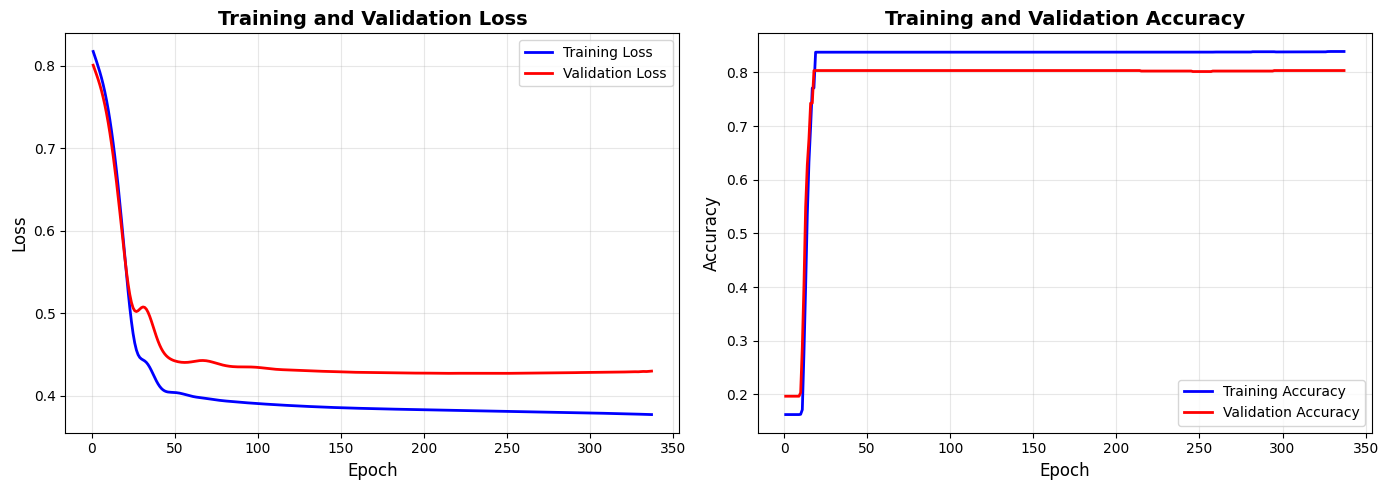

best_epoch,▁
best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇█
patience_counter,▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▃▁▁▁▂▃▃▄▆▆▇▇▇██
test_accuracy,▁
test_f1,▁
test_loss,▁
test_precision,▁
test_recall,▁
total_epochs_trained,▁
+4,...



Test Results:
Accuracy:  0.8504 (85.04%)
Precision: 0.5000
Recall:    0.0372
F1 Score:  0.0693

Confusion Matrix:
  True Negatives:  1062
  False Positives: 7
  False Negatives: 181
  True Positives:  7

Detailed Classification Report:
              precision    recall  f1-score   support

    No Match       0.85      0.99      0.92      1069
       Match       0.50      0.04      0.07       188

    accuracy                           0.85      1257
   macro avg       0.68      0.52      0.49      1257
weighted avg       0.80      0.85      0.79      1257



In [222]:
predicting = "match"
X = df_dating[
    [
        "d_attractive_partner",
        "d_funny_partner",
        "d_shared_interests_partner",
        "d_sincere_partner",
        "d_intelligence_partner",
        "d_ambition_partner",
    ]
].values
y = df_dating[predicting].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=0
)

# Train with early stopping
model, scaler, history = train_model(
    X_train,
    y_train,
    num_epochs=5000,
    learning_rate=0.001,
    patience=100,
    use_wandb=True,
    run_name="mmatch_with_early_stopping",
)

# Plot training curves
plot_training_history(history)

# Evaluate
accuracy, predictions, metrics = evaluate_model(
    model, scaler, X_test, y_test, use_wandb=True
)


In [176]:
model, scaler = train_model(X_train, y_train, num_epochs=5000)

accuracy, predictions1 = evaluate_model(model, scaler, X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Predicted labels array:", predictions1)

Split training data: 5696 train, 1006 validation


✓ WandB run initialized successfully

Starting training with early stopping (patience=200)...
Epoch [1/5000] - Train Loss: 0.6866, Train Acc: 0.5781 | Val Loss: 0.6869, Val Acc: 0.5716 | Patience: 0/200
Epoch [100/5000] - Train Loss: 0.6042, Train Acc: 0.6606 | Val Loss: 0.5931, Val Acc: 0.6640 | Patience: 0/200
Epoch [200/5000] - Train Loss: 0.5394, Train Acc: 0.7207 | Val Loss: 0.5206, Val Acc: 0.7346 | Patience: 0/200
Epoch [207/5000] - Train Loss: 0.5383, Train Acc: 0.7212 | Val Loss: 0.5198, Val Acc: 0.7346 | Patience: 1/200
Epoch [209/5000] - Train Loss: 0.5381, Train Acc: 0.7210 | Val Loss: 0.5196, Val Acc: 0.7346 | Patience: 1/200
Epoch [211/5000] - Train Loss: 0.5378, Train Acc: 0.7212 | Val Loss: 0.5194, Val Acc: 0.7346 | Patience: 1/200
Epoch [213/5000] - Train Loss: 0.5376, Train Acc: 0.7212 | Val Loss: 0.5193, Val Acc: 0.7336 | Patience: 1/200
Epoch [215/5000] - Train Loss: 0.5374, Train Acc: 0.7209 | Val Loss: 0.5192, Val Acc: 0.7336 | Patience: 1/200
Epoch [217/5000] - T

ValueError: too many values to unpack (expected 2)

In [ ]:
predicting = "decision_o"
X = df_dating[
    [
        "d_attractive_o",
        "d_funny_o",
        "d_shared_interests_o",
        "d_sinsere_o",
        "d_intelligence_o",
        "d_ambitous_o",
    ]
].values

y = df_dating[predicting].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27
)

In [ ]:
model, scaler = train_model(X_train, y_train, num_epochs=5000)
accuracy, predictions2 = evaluate_model(model, scaler, X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Predicted labels array:", predictions2)

Epoch [1/5000], Loss: 0.7029, Accuracy: 0.5012
Epoch [100/5000], Loss: 0.5970, Accuracy: 0.6595
Epoch [200/5000], Loss: 0.5356, Accuracy: 0.7223
Epoch [300/5000], Loss: 0.5298, Accuracy: 0.7275
Epoch [400/5000], Loss: 0.5286, Accuracy: 0.7277
Epoch [500/5000], Loss: 0.5278, Accuracy: 0.7275
Epoch [600/5000], Loss: 0.5273, Accuracy: 0.7280
Epoch [700/5000], Loss: 0.5268, Accuracy: 0.7289
Epoch [800/5000], Loss: 0.5264, Accuracy: 0.7293
Epoch [900/5000], Loss: 0.5260, Accuracy: 0.7292
Epoch [1000/5000], Loss: 0.5256, Accuracy: 0.7293
Epoch [1100/5000], Loss: 0.5253, Accuracy: 0.7307
Epoch [1200/5000], Loss: 0.5249, Accuracy: 0.7317
Epoch [1300/5000], Loss: 0.5245, Accuracy: 0.7325
Epoch [1400/5000], Loss: 0.5241, Accuracy: 0.7325
Epoch [1500/5000], Loss: 0.5238, Accuracy: 0.7332
Epoch [1600/5000], Loss: 0.5234, Accuracy: 0.7328
Epoch [1700/5000], Loss: 0.5229, Accuracy: 0.7329
Epoch [1800/5000], Loss: 0.5226, Accuracy: 0.7332
Epoch [1900/5000], Loss: 0.5222, Accuracy: 0.7334
Epoch [2000/

epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
test_accuracy,▁
test_f1,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█████████████
train_loss,█▅▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,5000
test_accuracy,0.69153
test_f1,0.64122



Test Results:
Accuracy: 0.6915
Precision: 0.6346
Recall: 0.6480
F1 Score: 0.6412
Accuracy: 69.15%
Predicted labels array: [0. 0. 1. ... 1. 0. 1.]


In [ ]:
correct = 0

for i in range(len(predictions1)):
    if predictions1[i] == 1 and predictions2[i] == 1:
        correct += 1

print(
    f"Correct: {correct}/{len(predictions1)} = {correct / len(predictions1) * 100:.2f}%"
)

Correct: 313/1676 = 18.68%


In [ ]:
predicting = "match"
X = df_dating[
    [
        "d_like",
        "d_funny_o",
        "d_funny_partner",
        "d_shared_interests_o",
        "d_shared_interests_partner",
        "d_guess_prob_liked",
        "d_attractive_o",
        "d_attractive_partner",
    ]
].values

# X = df_dating[['d_attractive_partner', 'd_funny_partner','d_shared_interests_partner','d_sincere_partner','d_intelligence_partner','d_ambition_partner', 'd_attractive_o', 'd_funny_o','d_shared_interests_o','d_sinsere_o','d_intelligence_o','d_ambitous_o']].values

y = df_dating[predicting].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
model, scaler = train_model(X_train, y_train, num_epochs=5000)
accuracy, predictions_match = evaluate_model(model, scaler, X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

print("Predicted labels array:", predictions_match)


Epoch [1/5000], Loss: 0.7691, Accuracy: 0.2077
Epoch [100/5000], Loss: 0.4118, Accuracy: 0.8371
Epoch [200/5000], Loss: 0.3471, Accuracy: 0.8390
Epoch [300/5000], Loss: 0.3409, Accuracy: 0.8436
Epoch [400/5000], Loss: 0.3384, Accuracy: 0.8493
Epoch [500/5000], Loss: 0.3367, Accuracy: 0.8502
Epoch [600/5000], Loss: 0.3356, Accuracy: 0.8518
Epoch [700/5000], Loss: 0.3348, Accuracy: 0.8532
Epoch [800/5000], Loss: 0.3342, Accuracy: 0.8533
Epoch [900/5000], Loss: 0.3336, Accuracy: 0.8535
Epoch [1000/5000], Loss: 0.3332, Accuracy: 0.8541
Epoch [1100/5000], Loss: 0.3327, Accuracy: 0.8548
Epoch [1200/5000], Loss: 0.3324, Accuracy: 0.8557
Epoch [1300/5000], Loss: 0.3319, Accuracy: 0.8545
Epoch [1400/5000], Loss: 0.3316, Accuracy: 0.8545
Epoch [1500/5000], Loss: 0.3313, Accuracy: 0.8544
Epoch [1600/5000], Loss: 0.3310, Accuracy: 0.8548
Epoch [1700/5000], Loss: 0.3306, Accuracy: 0.8553
Epoch [1800/5000], Loss: 0.3303, Accuracy: 0.8554
Epoch [1900/5000], Loss: 0.3299, Accuracy: 0.8556
Epoch [2000/

epoch,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
test_accuracy,▁
test_f1,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃██████████████████████████████████████
train_loss,█▇▆▆▆▆▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch,5000
test_accuracy,0.84069
test_f1,0.35971



Test Results:
Accuracy: 0.8407
Precision: 0.5769
Recall: 0.2613
F1 Score: 0.3597
Accuracy: 84.07%
Predicted labels array: [0. 0. 1. ... 0. 0. 0.]


In [ ]:
TN = 0
FP = 0
FN = 0
TP = 0

for i in range(len(predictions_match)):
    if df_dating["match"][i] == 0 and predictions_match[i] == 0:
        TN += 1
    if df_dating["match"][i] == 0 and predictions_match[i] == 1:
        FP += 1
    if df_dating["match"][i] == 1 and predictions_match[i] == 0:
        FN += 1
    if df_dating["match"][i] == 1 and predictions_match[i] == 1:
        TP += 1

print(f"{TP / (TP + FP)}")

0.16923076923076924
